<a href="https://colab.research.google.com/github/ashutosh3060/friday-burger-mojito/blob/master/eda_model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Table of Contents**

0. **Libraries**
1. **User-Defined Functions**
2. **Import Data**
3. **Exploratory Data Analysis**   
  3.1 Class Imbalance for Target variable   
  3.2 Bivariate Analysis
        3.2.1 Continuous variables
        3.2.2 Multi-category categorical variables
        3.2.2 Binary categorical variables
  3.3 Multi-variate Analysis   
  3.4 Outlier Analysis   
        3.4.1 Boxplots     
        3.4.2 Scatter Plots
        3.4.3 IQR    
        3.4.4 Z-score   
  3.5 Correlation Matrix
4. **Data Preparation for Model Building**   
  4.1 Feature Selection    
  4.2 Train-Validation split   
  4.3 Imbalanced Data Handling   
        4.3.1 Undersampling
        4.3.2 Oversampling
5. **Model Build**  
  Train and prediction for various models   
  5.1 Binary output-based model  
        Metric for Evaluation
              1. F1-score
              2. Classification Report
              3. Confusion matrix component
  5.2 Probability based model
        Metric for Evaluation
              1. ROC score, plots
              2. Capture curve
              3. Decile-based probability
6. **Hyperparameter Tuning**
7. **Cross Validation**
8. **Feature Importance**
9. **Save the Best Model**
9. **Final Recommendation**

## 0. Libraries

In [1]:
# warnings
import warnings
warnings.filterwarnings("ignore")

# Dataframe, numerical exp and other python-native libraries
import time
from collections import Counter
import pickle
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score
# XGBoost
from xgboost import XGBClassifier, plot_importance

# imblearn for imbalanced data handling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Display Settings
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

## 1. User-Defined Functions

In [56]:
def bivar_contns(nonreturn_df, return_df, contns_col):
    '''
    Plots the continuous variable's histogram for the returning and non-returning customers

    Inputs
    ----------
    nonreturn_df : dataframe
        Dataframe containing Non-returning customers only
    return_df : dataframe
        Dataframe containing Returning customers only
    contns_col : srtring
        Continuous variable name

    Output
    -------
    Histogram in subplots (2 plots)
        Side-by-side histograms of the continuous variable for Non-returning and Returning Customers
    '''
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    nonreturn_df.hist(contns_col, bins=100, ax=axes[0])
    axes[0].set_title('non-returning')
    axes[0].set_xlabel(contns_col)
    return_df.hist(contns_col, bins=100, ax=axes[1])
    axes[1].set_title('returning')
    axes[1].set_xlabel(contns_col)
    plt.show()

def bivar_multi_cat(df, feature, target_ftr, label_rotation=False, horizontal_layout=True):
    '''
    Plots the multi-value categorical variable's bar-graph showing categories in x-axis and #returning_customers in y-axis

    Inputs
    ----------
    df : dataframe
        Dataframe containing Non-returning customers only
    feature : string
        Categorical variable name
    target_ftr : srtring
        Target variable name

    Output
    -------
    Bar-graph
        Bar graph: x-axis->Unique categories, y-axis->#Returning_customers
    '''
    plt.figure(figsize=(8,6))
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'# Returning Customers': temp.values})
    cat_perc = df[[feature, target_ftr]].groupby([feature],as_index=False).mean() # Calculate the percentage of target=1 per category value
    cat_perc.sort_values(by=target_ftr, ascending=False, inplace=True)
    sns.set_color_codes("pastel")
    s = sns.barplot(x = feature, y="# Returning Customers",data=df1)
    if(label_rotation):
        s.set_xticklabels('',rotation=60)
    s.set_title(feature)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

def bivar_binary_cat(df, feature, target_var):
    '''
    Plots Bar-graph using Cross-tab for binary categorical variable and target class

    Inputs
    ----------
    df : dataframe
        Dataframe containing Non-returning customers only
    feature : string
        Binary categorical variable name
    target_ftr : srtring
        Target variable name

    Output
    -------
    Bar-graph
        Bar graph: x-axis->target_ftr, y-axis->Binary categorical variable
    '''
    ct = pd.crosstab(df[target_var],df_order_label[feature]).apply(lambda r: round((r/r.sum())*100,1), axis=1)
    ct.plot.bar(stacked=True) 
    plt.xlabel(target_var)
    plt.ylabel(feature)
    plt.title(f"{target_var}  vs  {feature}") 
    plt.legend(bbox_to_anchor=(1.25,1.15), loc="upper right")
    plt.show()

def plot_roc(y_actual, y_pred):
    '''
    Plots the ROC curve and gives the ROC AUC value.

    Inputs
    ----------
    y_actual : Pandas Series
        Actual target value
    y_pred : Pandas Series
        Predicted target value out of model prediction

    Output
    -------
    ROC AUC Plot
        A graph showing False positive rate (x-axis) vs True positive rate (y-axis) for the target variable
        Range for Area under the curve value : 0 to 1 
                                              (0 being the worst and 1 being the best for predictive model)
    '''
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    roc_auc = roc_auc_score(y_actual, y_pred)
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='random')
    plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def perf_measure(y_actual, y_pred):
    '''
    Calculates the True Positive,  False Positive, True Negative,  False Negative values 

    Inputs
    ----------
    y_actual : Pandas Series
        Actual target value
    y_pred : Pandas Series
        Predicted target value out of model prediction

    Output
    -------
    TP, FP, TN, FN
        Number of records falling under 4 components of the confusion-matrix
    '''
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP += 1
        if y_actual[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FN += 1

    return(TP, FP, TN, FN)

def capture_curve(df, y_actual, y_pred, roc, title):
    '''
    Plots the % of Actual Returning Customers captured out of overall customers, in each decile 

    Inputs
    ----------
    df : dataframe
        Dataframe having the population for which capture curve is to be plotted
    y_actual : Pandas Series
        Actual target value
    y_pred : Pandas Series
        Predicted target value out of model prediction
    roc : float
        ROC AUC value calculated from actual and predicted values
    title : string
        Title for the capture curve

    Output
    -------
    Capture curve
        A graph showing % of overall customers (from 1st to 10th decile) in x-axis and % of returning customers in y-axis
        Deciles are sorted (descending) based on predicted probability for customers being a returning customer in the next 6 months.
        1st decile -> 10th decile : Highest Probability -> Lowest probability
    '''
    fpr, tpr, threshold = roc_curve(y_actual, y_pred)
    roc_auc = auc(fpr, tpr)
    rate = []
    for i in threshold:
        T = perf_measure(list(y_actual),[1 if j >= i else 0 for j in y_pred])
        rate.append(T[0]+T[1])
    rate2 = [i/len(df) for i in rate]
    plt.figure(figsize=[12,12])
    plt.plot(rate2, tpr, label='ROC_AUC {}'.format(roc) % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('All Customers', fontsize=18)
    plt.ylabel('Captured out of total Returning proportion', fontsize=18)
    plt.title('Capture plot for {}'.format(title), fontsize=18)
    plt.legend(loc="lower right",prop={'size':30})
    plt.show()

def decile_cutoff_return_detected(df_pred, unique_id_name, target_act_name, target_pred_name):
    '''
    Returns the Dataframe with decile-wise count, percentage of returning customer and minimum, maximum and average predicted probability of each decile.

    Inputs
    ----------
    df_pred: Dataframe
        Dataframe with unique_id, actual and predicted(probability) value for the target
    unique_id_name: string
        unique identifier name in the dataframe
    target_act_name: string
        Actual target value name
    target_pred_name: string
        Predicted target value name

    Output
    -------
    Result Dataframe
        Dataframe with calculated fields
    '''
    pop_perc = list(np.arange(0.1,1.1,0.1))
    perc_list = []
    return_perc_list = []
    return_num_list = []
    avg_pred_prob_list = []
    min_pred_prob_list = []
    max_pred_prob_list = []
    df_pop_return = pd.DataFrame(columns=['customer_population_%', 'return_%', 'return_count', 'avg_pred_prob'])
    total_return_count = df_pred[df_pred[target_act_name]==1][unique_id_name].count()
    start = 0
    for perc in pop_perc:
        split_len = int(perc*len(df_pred))
        sorted_results_final = df_pred.iloc[start:split_len]
        return_count = sorted_results_final[sorted_results_final[target_act_name]==1][unique_id_name].count()
        min_pred_prob = sorted_results_final[target_pred_name].min()
        max_pred_prob = sorted_results_final[target_pred_name].max()
        avg_pred_prob = sorted_results_final[target_pred_name].mean()
        perc_list.append(int(perc*100))
        return_perc_list.append(round(((return_count/total_return_count)*100),2))
        return_num_list.append(round(return_count,2))
        min_pred_prob_list.append(round(min_pred_prob, 2))
        max_pred_prob_list.append(round(max_pred_prob, 2))
        avg_pred_prob_list.append(round(avg_pred_prob, 2))
        start = split_len
    df_pop_return['customer_population_%'] = perc_list
    df_pop_return['return_%'] = return_perc_list  
    df_pop_return['return_count'] = return_num_list
    df_pop_return['avg_pred_prob'] = avg_pred_prob_list
    df_pop_return['min_pred_prob'] = min_pred_prob_list
    df_pop_return['max_pred_prob'] = max_pred_prob_list
    return df_pop_return

def cum_decile_cutoff_return_detected(df_pred, unique_id_name, target_act_name, target_pred_name):
    '''
    Returns the Dataframe with decile-wise cumulative count, percentage of returning customer and cumulative minimum, maximum and average predicted probability of each decile.

    Inputs
    ----------
    df_pred: Dataframe
        Dataframe with unique_id, actual and predicted(probability) value for the target
    unique_id_name: string
        unique identifier name in the dataframe
    target_act_name: string
        Actual target value name
    target_pred_name: string
        Predicted target value name

    Output
    -------
    Result Dataframe
        Dataframe with calculated fields
    '''
    pop_perc = list(np.arange(0.1,1.1,0.1))
    perc_list = []
    return_perc_list = []
    return_num_list = []
    avg_pred_prob_list = []
    min_pred_prob_list = []
    max_pred_prob_list = []
    df_pop_return = pd.DataFrame(columns=['customer_population_%','cumulative_return_%', 'cumulative_return_count', 'avg_pred_prob'])
    total_return_count = df_pred[df_pred[target_act_name]==1][unique_id_name].count()
    for perc in pop_perc:
        split_len = int(perc*len(df_pred))
        sorted_results_final = df_pred.iloc[:split_len]
        return_count = sorted_results_final[sorted_results_final[target_act_name]==1][unique_id_name].count()
        min_pred_prob = sorted_results_final[target_pred_name].min()
        max_pred_prob = sorted_results_final[target_pred_name].max()
        avg_pred_prob = sorted_results_final[target_pred_name].mean()
        perc_list.append(int(perc*100))
        return_perc_list.append(round(((return_count/total_return_count)*100),2))
        return_num_list.append(round(return_count,2))
        min_pred_prob_list.append(round(min_pred_prob, 2))
        max_pred_prob_list.append(round(max_pred_prob, 2))
        avg_pred_prob_list.append(round(avg_pred_prob, 2))
    df_pop_return['customer_population_%'] = perc_list
    df_pop_return['cumulative_return_%'] = return_perc_list  
    df_pop_return['cumulative_return_count'] = return_num_list
    df_pop_return['avg_pred_prob'] = avg_pred_prob_list
    df_pop_return['min_pred_prob'] = min_pred_prob_list
    df_pop_return['max_pred_prob'] = max_pred_prob_list
    return df_pop_return

## 2. Import Data

In [2]:
# Define the path, filename

order_label_path = "/content/"
order_label_file = "customer_order_label.csv"

In [3]:
# import the dataset as a dataframe

df_order_label = pd.read_csv(order_label_path+order_label_file)

In [4]:
# shape and first few records

print(df_order_label.shape)
df_order_label.head(3)

(244937, 53)


,customer_id,is_returning_customer,first_order_before,last_order_before,cntns_order_period,comm_orderhour,num_success_order,num_fail_order,is_voucher,avg_voucher_amnt,is_deliveryfee,avg_deliveryfee,is_amount,avg_amount,num_restaurant,num_city,num_paymentid,num_platform,num_transmission,order_afternoon,order_early_morning,order_evening,order_late_night,order_morning,order_night,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_525,platform_id_22167,platform_id_22263,platform_id_22295,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,transmission_id_212,transmission_id_1988,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124
0,000097eabfd9,0,620,620,1,19,1,0,0,0.0,0,0.000,1,11.46960,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
1,0000e2c6d9be,0,397,397,1,20,1,0,0,0.0,0,0.000,1,9.55800,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2,000133bb597f,1,3,3,1,19,1,0,0,0.0,1,0.493,1,5.93658,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0


## 3. Exploratory Data Analysis

### 3.1 Class Imbalance for Target variable

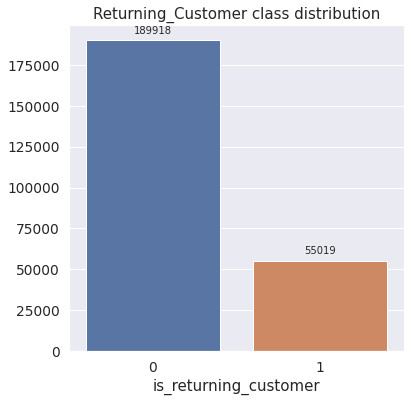

In [5]:
# Class Imbalance check with visualization

df_cls = df_order_label.copy() # create a copy for class-distribution calculation

df_cls_dist = df_cls["is_returning_customer"].value_counts()
df_cls_rpd = pd.DataFrame({'labels': df_cls_dist.index, 'values': df_cls_dist.values})
plt.figure(figsize = (6,6))
plt.title('Returning_Customer class distribution')
sns.set_color_codes("pastel")
splot = sns.barplot(x = 'labels', y="values", data=df_cls_rpd)
splot.set(xlabel='is_returning_customer', ylabel='', title='Returning_Customer class distribution')
for p in splot.patches:
    splot.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
locs, labels = plt.xticks()
plt.show()

In [6]:
# printing the first few records to define the structure of analysis

df_order_label.head()

,customer_id,is_returning_customer,first_order_before,last_order_before,cntns_order_period,comm_orderhour,num_success_order,num_fail_order,is_voucher,avg_voucher_amnt,is_deliveryfee,avg_deliveryfee,is_amount,avg_amount,num_restaurant,num_city,num_paymentid,num_platform,num_transmission,order_afternoon,order_early_morning,order_evening,order_late_night,order_morning,order_night,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_525,platform_id_22167,platform_id_22263,platform_id_22295,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,transmission_id_212,transmission_id_1988,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124
0,000097eabfd9,0,620,620,1,19,1,0,0,0.0,0,0.000,1,11.46960,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
1,0000e2c6d9be,0,397,397,1,20,1,0,0,0.0,0,0.000,1,9.55800,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2,000133bb597f,1,3,3,1,19,1,0,0,0.0,1,0.493,1,5.93658,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
3,00018269939b,0,24,24,1,17,1,0,0,0.0,1,0.493,1,9.82350,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
4,0001a00468a6,0,575,575,1,19,1,0,0,0.0,1,0.493,1,5.15070,1,1,1,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0


In [7]:
# Features

df_order_label.columns

Index(['customer_id', 'is_returning_customer', 'first_order_before',
       'last_order_before', 'cntns_order_period', 'comm_orderhour',
       'num_success_order', 'num_fail_order', 'is_voucher', 'avg_voucher_amnt',
       'is_deliveryfee', 'avg_deliveryfee', 'is_amount', 'avg_amount',
       'num_restaurant', 'num_city', 'num_paymentid', 'num_platform',
       'num_transmission', 'order_afternoon', 'order_early_morning',
       'order_evening', 'order_late_night', 'order_morning', 'order_night',
       'payment_id_1491', 'payment_id_1523', 'payment_id_1619',
       'payment_id_1779', 'payment_id_1811', 'platform_id_525',
       'platform_id_22167', 'platform_id_22263', 'platform_id_22295',
       'platform_id_29463', 'platform_id_29495', 'platform_id_29751',
       'platform_id_29815', 'platform_id_30135', 'platform_id_30199',
       'platform_id_30231', 'platform_id_30359', 'platform_id_30391',
       'platform_id_30423', 'transmission_id_212', 'transmission_id_1988',
       'transm

### 3.2 Bivariate Analysis

#### 3.2.1 **Continuous Variables**

1. First order is before how many days  
2. Last order is before how many days  
3. Customer's all orders fall between how many days  
4. Most common order_hour of Customers  
5. Number of successful orders    
6. Number of failed orders    
7. Average Voucher amount used   
8. Average Delivery fee paid   
9. Average amount paid   

In [8]:
# Create 2 different temporary dataframes for returning and non-returning customers

nonreturn_df = df_order_label.loc[df_order_label["is_returning_customer"]==0]
return_df = df_order_label.loc[df_order_label["is_returning_customer"]==1]
print(f'Number of Non-returning customers: {nonreturn_df.shape[0]},   Number of Returning customers: {return_df.shape[0]}')

Number of Non-returning customers: 189918,   Number of Returning customers: 55019


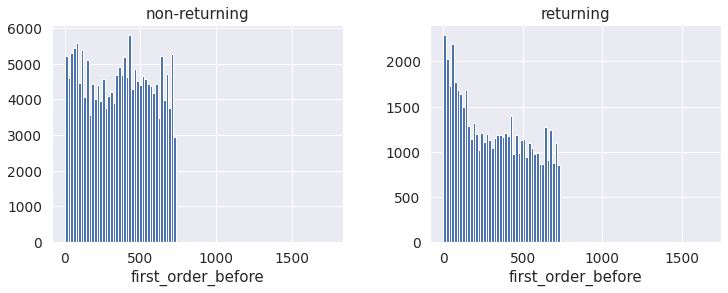

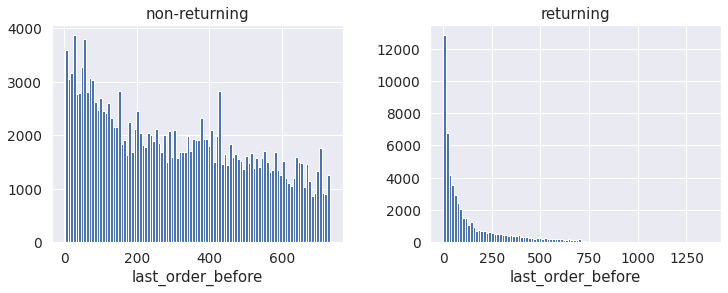

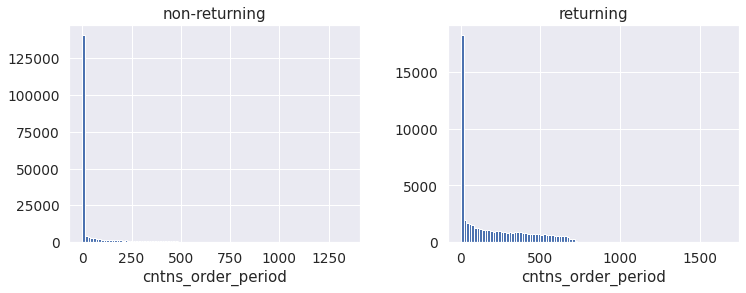

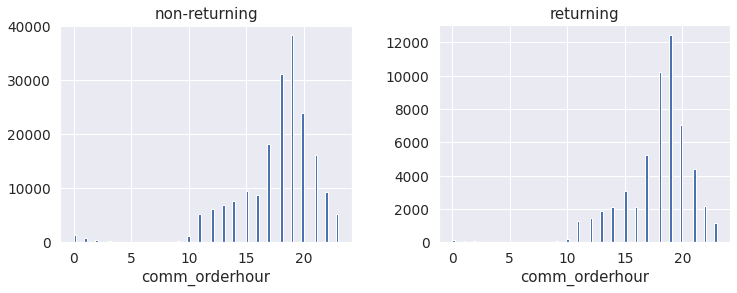

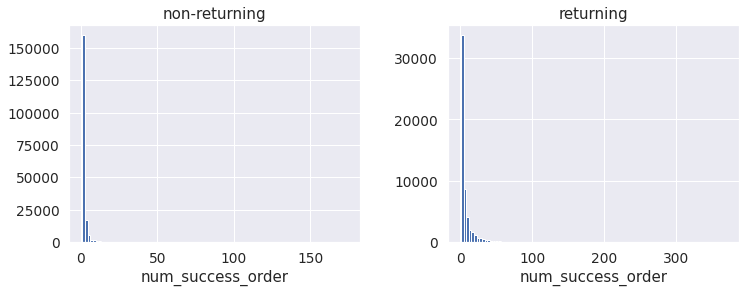

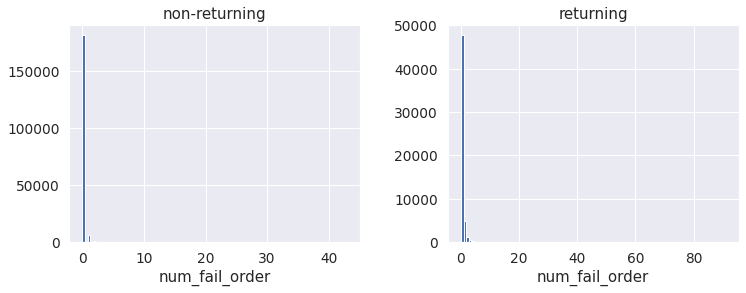

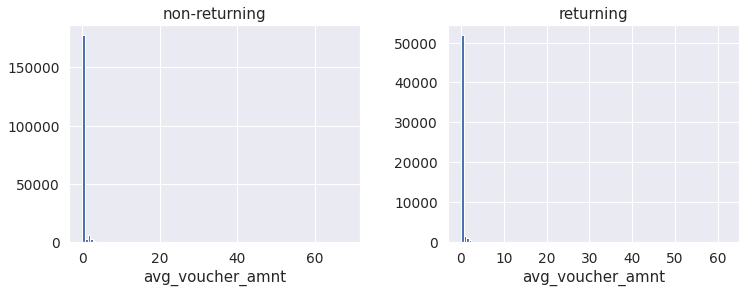

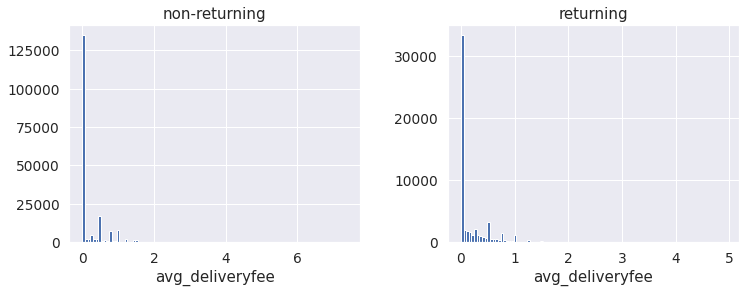

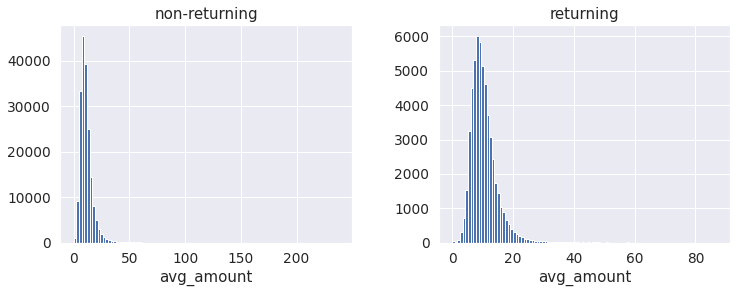

In [11]:
contns_vars = ["first_order_before", "last_order_before", "cntns_order_period", "comm_orderhour", 
               "num_success_order", "num_fail_order", "avg_voucher_amnt", "avg_deliveryfee", 
               "avg_amount"]

for var in contns_vars:
    bivar_contns(nonreturn_df, return_df, var)

* Significantly large difference between histograms of returning and non-returning customers for **last_order_before** feature

#### 3.2.2 **Multi-category categorical variables**

1. Returning Customer distribution based on **Number of unique restaurants ordered from**   
2. Returning Customer distribution based on **Number of unique cities ordered from**    
3. Returning Customer distribution based on **Number of unique payment_id used**    
4. Returning Customer distribution based on **Number of unique platform used**   
5. Returning Customer distribution based on **Number of unique transmission used**  

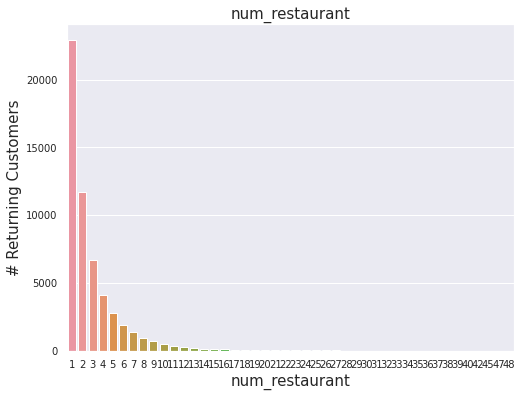

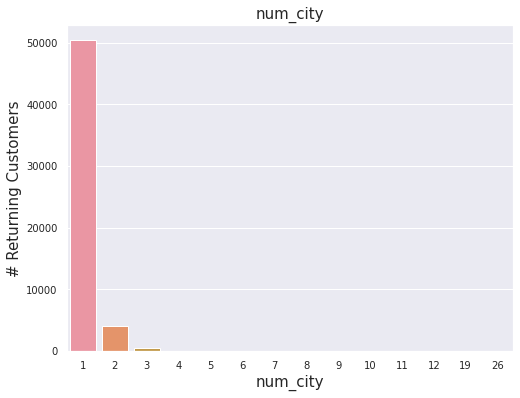

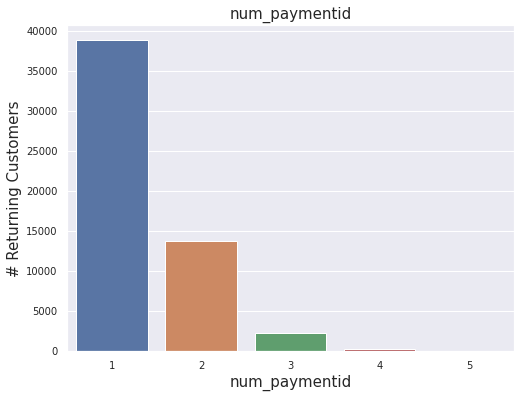

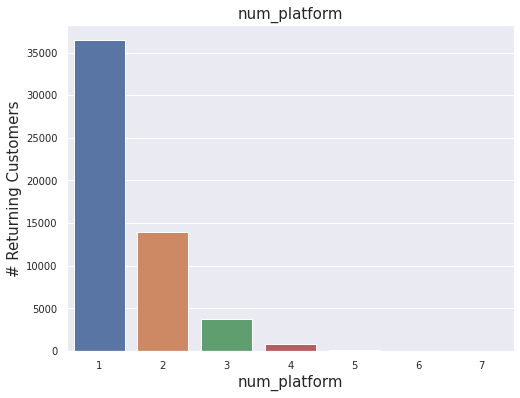

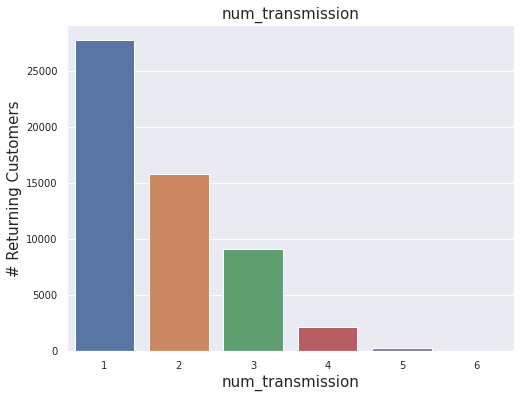

In [12]:
categorical_vars = [ "num_restaurant", "num_city", "num_paymentid", "num_platform", "num_transmission"]
target_var = "is_returning_customer"

for var in categorical_vars:
    bivar_multi_cat(return_df, var, target_var, label_rotation=False, horizontal_layout=True)


#### 3.2.3 **Binary categorical variables**

1. Returning Status vs **Voucher used or not**   
2. Returning Status vs **Delivery fee paid or not**    
3. Returning Status vs **Ever paid any amount or not**    

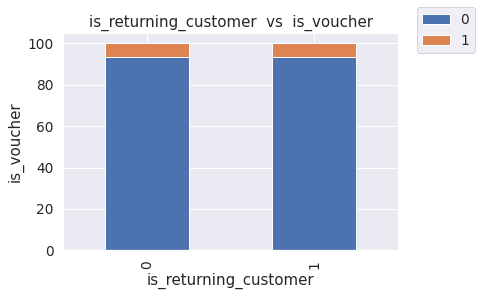

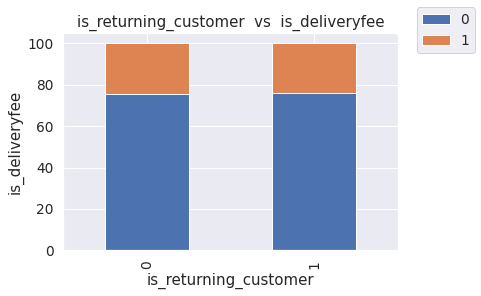

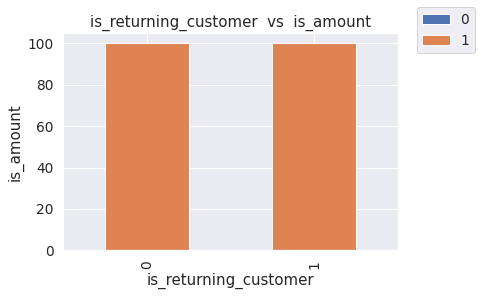

In [13]:
# For all the binary categorical variable plot the crosstab with target variable
binary_vars = ["is_voucher", "is_deliveryfee", "is_amount"]
target_var = "is_returning_customer"

for var in binary_vars:
    bivar_binary_cat(df_order_label, var, target_var)

* Can't see any significance difference in distribution for binary categorical features vs the target variable.
* Need to check, is there even a single customer present who has not paid any amount (May be due to fail order or fraud in payment or any such issues)

In [14]:
# 1. Check the number customers who has not paid ever
# 2. If any present, check the distribution of returning and non-returning customers 
print(df_order_label.loc[df_order_label["is_amount"]==0].shape[0])
df_order_label.loc[df_order_label["is_amount"]==0]["is_returning_customer"].value_counts()

583


0    502
1     81
Name: is_returning_customer, dtype: int64

* As 583 is a small number out of 0.24 million, couldn't recognize in the plot.
* Distributiopn of customer's returning status is similar as of overall data.

### 3.3 Multi-variate Analysis

**Will save it for future work**

### 3.4 Outlier Analysis

3.4.1 Boxplots        
3.4.2 Scatter Plots   
3.4.3 IQR    
3.4.4 Z-score     

* Scatter Plots and Z-score will do in future (due to time constraints)

#### 3.4.1 Boxplots

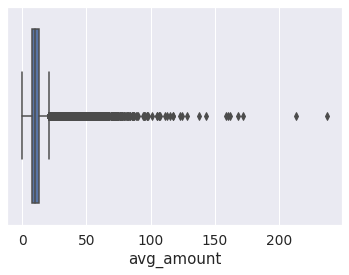

In [15]:
# boxplot for amount paid
sns.boxplot(x=df_order_label["avg_amount"])
plt.show()

* Need to check for Returning Customer Distribution for customers having <50 and >=50 average amount paid

In [16]:
print("Customer spent < 50")
print('--'*20)
print(f'#customers: {df_order_label.loc[df_order_label["avg_amount"]<50].shape[0]}')
print(df_order_label.loc[df_order_label["avg_amount"]<50]["is_returning_customer"].value_counts())
print('**'*20)
print('**'*20)
print("Customer spent >= 50")
print('--'*20)
print(df_order_label.loc[df_order_label["avg_amount"]>=50].shape[0])
print(df_order_label.loc[df_order_label["avg_amount"]>=50]["is_returning_customer"].value_counts())

Customer spent < 50
----------------------------------------
#customers: 244627
0    189629
1     54998
Name: is_returning_customer, dtype: int64
****************************************
****************************************
Customer spent >= 50
----------------------------------------
310
0    289
1     21
Name: is_returning_customer, dtype: int64


* There is no significance evidence that customers spending more are the returning ones.
* Need to dig deeper and before removing any values as outlier, need to check the final model's accuracy too.

##### For all other continuous variables

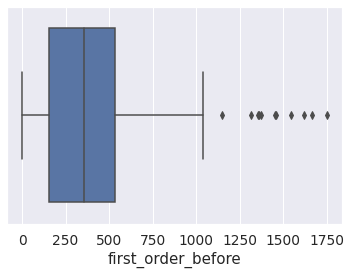

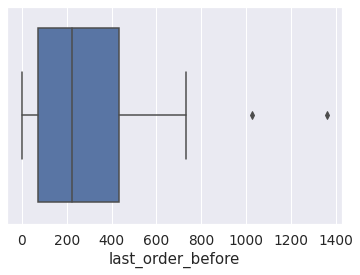

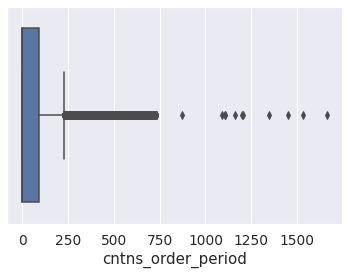

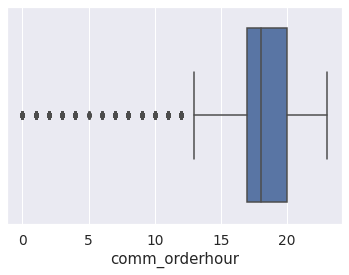

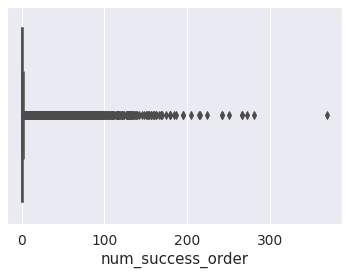

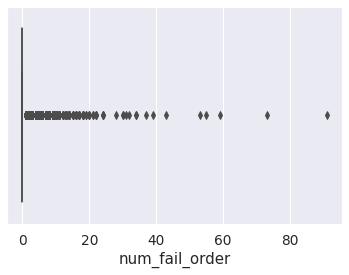

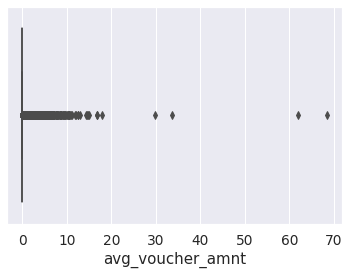

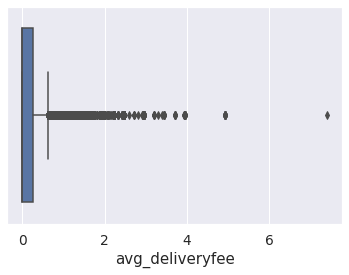

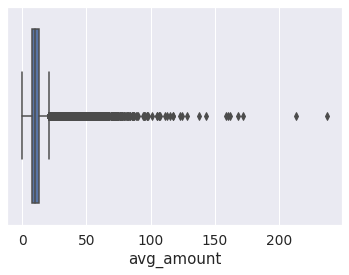

In [17]:
for var in contns_vars:
    sns.boxplot(x=df_order_label[var])
    plt.show()

#### 3.4.3 IQR Score

In [18]:
# Define Q1 and Q3 for IQR calculation

Q1 = df_order_label[contns_vars].quantile(0.25)
Q3 = df_order_label[contns_vars].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

first_order_before    378.00000
last_order_before     360.00000
cntns_order_period     91.00000
comm_orderhour          3.00000
num_success_order       1.00000
num_fail_order          0.00000
avg_voucher_amnt        0.00000
avg_deliveryfee         0.24650
avg_amount              5.43213
dtype: float64


In [20]:
# Calculate outlier percentage based on IQR concept

df_order_label_outlier = df_order_label[contns_vars][~((df_order_label[contns_vars] < (Q1 - 1.5 * IQR)) |(df_order_label[contns_vars] > (Q3 + 1.5 * IQR))).any(axis=1)]
outlier_percentage = (df_order_label_outlier.shape[0] / df_order_label[contns_vars].shape[0]) * 100
print(df_order_label[contns_vars].shape)
print(df_order_label_outlier.shape)
print(f"Outliuer percentage: {round(outlier_percentage,2)}")

(244937, 9)
(129881, 9)
Outliuer percentage: 53.03


* Saving these observations for future work
* Will check the model performance with and without outlier treatment
* Also some other methods such as **z-score**, **scatter-plot** can be tried further.

### 3.5 Correlation Matrix

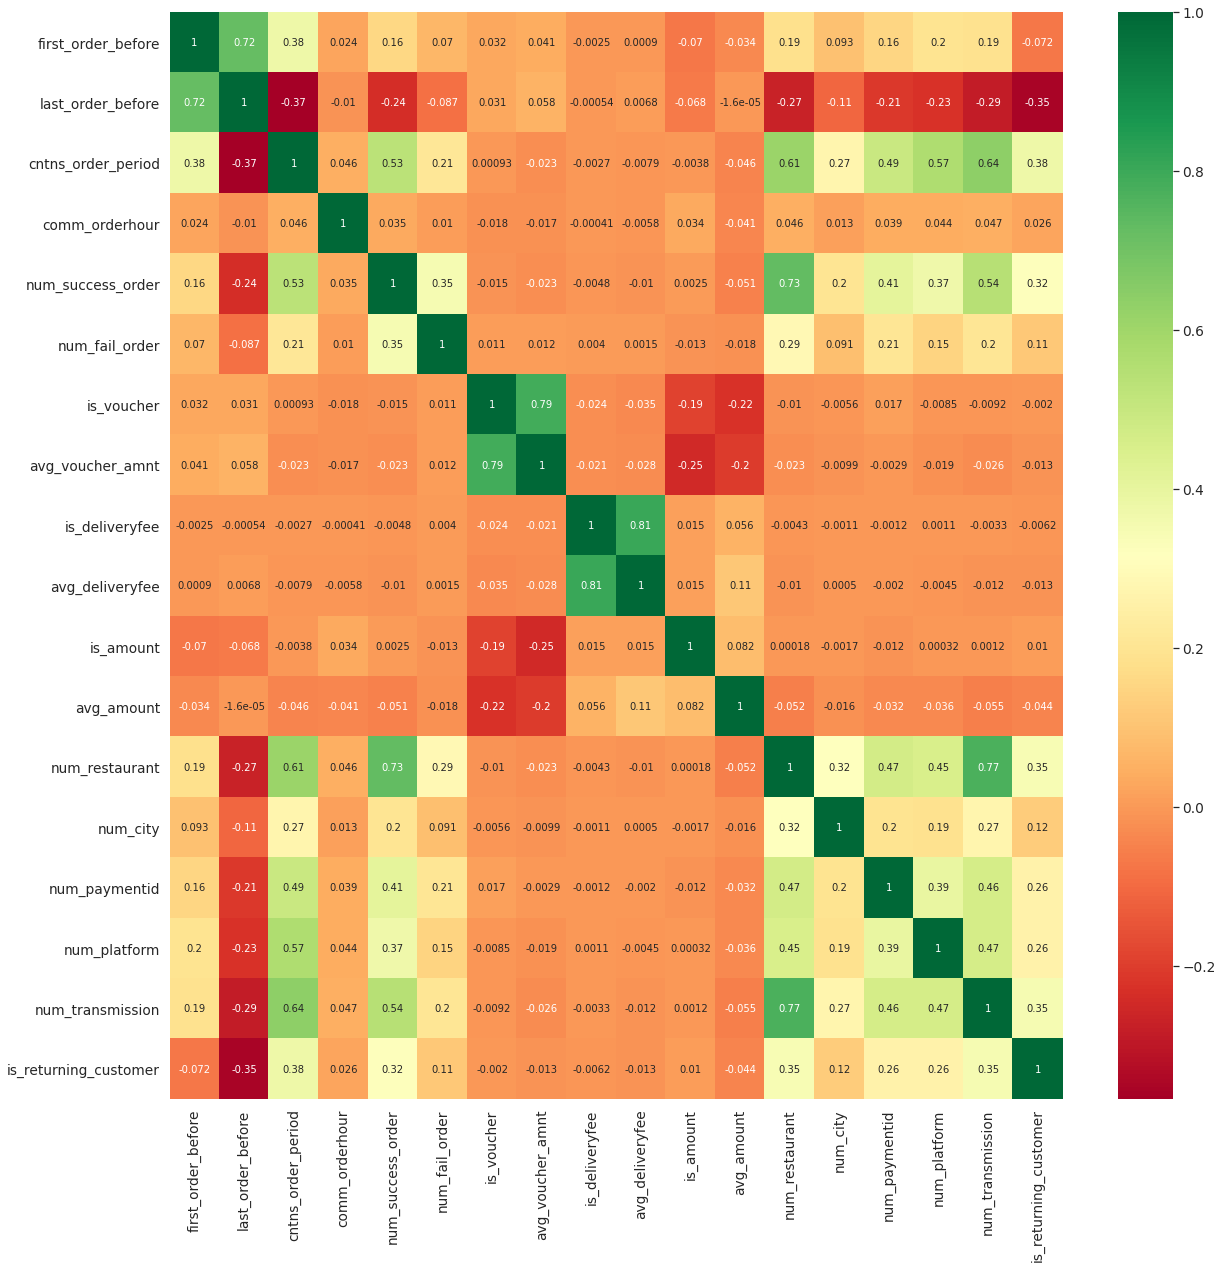

In [22]:
# Define all the variable set for correlation calculation
feature_set_corr = ['first_order_before', 'last_order_before', 'cntns_order_period',
                    'comm_orderhour', 'num_success_order', 'num_fail_order', 'is_voucher', 
                    'avg_voucher_amnt', 'is_deliveryfee', 'avg_deliveryfee', 'is_amount', 
                    'avg_amount', 'num_restaurant', 'num_city',
       'num_paymentid', 'num_platform', 'num_transmission', 'is_returning_customer']

#get correlations of each features in dataset
corr_mat = df_order_label[feature_set_corr].corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_order_label[top_corr_features].corr(),annot=True,cmap="RdYlGn")

* The above correlation matrix helps in knowing the multicollinearity between independent variables.
* Although it also shows correlation between independent and dependent variables, we may need to check other methods due to categorical target variable.

* **Starting from Logistic Regression to Tree and Gradient Boosting machines' predictive power is not impacted by presence of multicollinearity**; hence will park it only for independent feature correlation

## 4. Data preparation for Model Build

In [24]:
df_order_label.columns

Index(['customer_id', 'is_returning_customer', 'first_order_before',
       'last_order_before', 'cntns_order_period', 'comm_orderhour',
       'num_success_order', 'num_fail_order', 'is_voucher', 'avg_voucher_amnt',
       'is_deliveryfee', 'avg_deliveryfee', 'is_amount', 'avg_amount',
       'num_restaurant', 'num_city', 'num_paymentid', 'num_platform',
       'num_transmission', 'order_afternoon', 'order_early_morning',
       'order_evening', 'order_late_night', 'order_morning', 'order_night',
       'payment_id_1491', 'payment_id_1523', 'payment_id_1619',
       'payment_id_1779', 'payment_id_1811', 'platform_id_525',
       'platform_id_22167', 'platform_id_22263', 'platform_id_22295',
       'platform_id_29463', 'platform_id_29495', 'platform_id_29751',
       'platform_id_29815', 'platform_id_30135', 'platform_id_30199',
       'platform_id_30231', 'platform_id_30359', 'platform_id_30391',
       'platform_id_30423', 'transmission_id_212', 'transmission_id_1988',
       'transm

In [25]:
# Define independent feature set and target variable

feature_set = ['first_order_before', 'last_order_before', 'cntns_order_period', 'comm_orderhour', 'num_success_order', 'num_fail_order', 'is_voucher', 'avg_voucher_amnt', 'is_deliveryfee', 'avg_deliveryfee', 'is_amount', 'avg_amount', 'num_restaurant', 'num_city',
       'num_paymentid', 'num_platform', 'num_transmission', 'order_afternoon',
       'order_early_morning', 'order_evening', 'order_late_night',
       'order_morning', 'order_night', 'payment_id_1491', 'payment_id_1523', 'payment_id_1619',
       'payment_id_1779', 'payment_id_1811', 'platform_id_525',
       'platform_id_22167', 'platform_id_22263', 'platform_id_22295',
       'platform_id_29463', 'platform_id_29495', 'platform_id_29751',
       'platform_id_29815', 'platform_id_30135', 'platform_id_30199',
       'platform_id_30231', 'platform_id_30359', 'platform_id_30391',
       'platform_id_30423', 'transmission_id_212', 'transmission_id_1988',
       'transmission_id_4196', 'transmission_id_4228', 'transmission_id_4260',
       'transmission_id_4324', 'transmission_id_4356', 'transmission_id_4996',
       'transmission_id_21124']
target = 'is_returning_customer'

In [26]:
# Define dataframe X and y for independent and dependent variables

X = df_order_label[feature_set]
y = df_order_label[target]

### 4.1 Feature Selection

##### Techniques to try

1. ANOVA f-value
2. Check p-value, VIF, step-wise / cumulative accuracy for adding new features (*Logistic Regression*)
3. Feature Importance for Tree based models

1. ANOVA (For categorical traget variable)

In [27]:
# ANOVA feature selection for numeric input and categorical output

# define feature selection (Best 20 features based on f-value)
fs = SelectKBest(score_func=f_classif, k=20)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)
print(X_selected)

(244937, 20)
[[620. 620.   1. ...   0.   0.   0.]
 [397. 397.   1. ...   0.   0.   0.]
 [  3.   3.   1. ...   0. 100.   0.]
 ...
 [196. 167.  29. ...   0.   0.   0.]
 [333. 333.   1. ...   0.   0.   0.]
 [641. 641.   1. ...   0. 100.   0.]]


Need to check **step 2 and 3** while building Model pipeline

* In initial version of the model, I will feed all the features to train   
* Future-scope:   
Will remove features not significant from the feature selection concepts 2 and 3

### 4.2 Train-Validation split

In [28]:
# Insample train and validation split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'X_train: {X_train.shape[0]}')
print(f'X_val: {X_val.shape[0]}')
print(f'y_train: {y_train.shape[0]}')
print(f'y_val: {y_val.shape[0]}')

X_train: 195949
X_val: 48988
y_train: 195949
y_val: 48988


In [29]:
# Create a validation dataframe using X_val and y_val for future accuracy and other evaluation metric calculation
df_val = pd.merge(df_order_label["customer_id"], pd.DataFrame(X_val), left_index=True, right_index=True, how='right')
df_val = pd.merge(df_val, pd.DataFrame(y_val), left_index=True, right_index=True, how='left')
print(df_val.shape)

# Create a list out of y_val (As y_val is a Pandas Series)
y_val_list = list(y_val)
print(len(y_val_list))

(48988, 53)
48988


### 4.3 Imbalanced Data Handling

In [30]:
# Calculate Target class distribution
 
non_returning_perc = (df_order_label.loc[df_order_label["is_returning_customer"]==0].shape[0] / df_order_label.shape[0]) * 100
returning_perc = (df_order_label.loc[df_order_label["is_returning_customer"]==1].shape[0] / df_order_label.shape[0]) * 100
print("***Returning Customer class distribution***")
print(f'Non-Returning %: {round(non_returning_perc,2)}    Returning %: {round(returning_perc,2)}')

***Returning Customer class distribution***
Non-Returning %: 77.54    Returning %: 22.46


* Around 20% data is having returning customers.
* Although data-imbalance is not huge but still different sampling techniques can be tried and accuracy can be checked.

#### 4.3.1 Undersampling

In [31]:
# define undersampling strategy
random_undersample = RandomUnderSampler(sampling_strategy=0.5)

# create the undersampled dataset
X_randomunder, y_randomunder = random_undersample.fit_resample(X, y)

# summarize the new class distribution
print(Counter(y_randomunder))

Counter({0: 110038, 1: 55019})


#### 4.3.2 Oversampling

In [32]:
# define oversampling strategy
random_oversample = RandomOverSampler(sampling_strategy=0.5)
# smote = SMOTE(sampling_strategy=0.5)

# create the oversampled dataset
X_randomover, y_randomover = random_oversample.fit_resample(X, y)
# X_smote, y_smote = smote.fit_resample(X, y)

# summarize the new class distribution
print(Counter(y_randomover))

Counter({0: 189918, 1: 94959})


* With undersampling, we may lose some information on the non-returning class
* With oversampling, training on synthetic generation of returning customers' data might not give a very good accuracy.

* So, in an iterative process, by checking the model's performance, need to fix the percentage of sample to be under/over sampled.

## 5. Model Build

* Let's try different base models

#### 1. Logistic Regression

In [33]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train,y_train)
# prediction
pred_prob_val_logreg = logreg.predict_proba(X_val)[:, 1]
pred_val_logreg = logreg.predict(X_val)
# f1_score claculation
f1_score_logreg = f1_score(y_val_list, pred_val_logreg)
# roc calculation
roc_val_logreg = roc_auc_score(list(y_val), pred_prob_val_logreg)

#### 2. k Nearest Neighbor

In [34]:
# k Nearest Neighbor Classifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
# prediction
pred_prob_val_knn= knn.predict_proba(X_val)[:, 1]
pred_val_knn= knn.predict(X_val)
# f1_score claculation
f1_score_knn = f1_score(y_val_list, pred_val_knn)
# roc calculation
roc_val_knn = roc_auc_score(list(y_val), pred_prob_val_knn)

#### 3. Decision Tree

In [35]:
# Decision Tree Classifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
# prediction
pred_prob_val_dtc= dtc.predict_proba(X_val)[:, 1]
pred_val_dtc= dtc.predict(X_val)
# f1_score claculation
f1_score_dtc= f1_score(y_val_list, pred_val_dtc)
# roc calculation
roc_val_dtc = roc_auc_score(list(y_val), pred_prob_val_dtc)

#### 4. Random Forest

In [36]:
# Random Forest Classifier

rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
# prediction
pred_prob_val_rf= rf.predict_proba(X_val)[:, 1]
pred_val_rf= rf.predict(X_val)
# f1_score claculation
f1_score_rf = f1_score(y_val_list, pred_val_rf)
# roc calculation
roc_val_rf = roc_auc_score(list(y_val), pred_prob_val_rf)

#### 5. XGBoost

In [37]:
# XGBoost Classifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
# prediction
pred_prob_val_xgb= xgb.predict_proba(X_val)[:, 1]
pred_val_xgb= xgb.predict(X_val)
# f1_score claculation
f1_score_xgb = f1_score(y_val_list, pred_val_xgb)
# roc calculation
roc_val_xgb = roc_auc_score(list(y_val), pred_prob_val_xgb)

### 5.1 Binary output-based model

#### 5.1.1 F1-score comparison

In [38]:
# Define a dictionary for ML_model names and their respective F1-score
Model_F1score = {
    'ML Model' : ['Logistic Regression', 'kNN', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'F1_score' : [f1_score_logreg, f1_score_knn, f1_score_dtc, f1_score_rf, f1_score_xgb]
}

# Create a dataframe out of the dictionary and sort it based on descending F1-score
df_Model_F1score = pd.DataFrame(Model_F1score)
df_Model_F1score["F1_score"] = np.round(df_Model_F1score["F1_score"], 2)
df_Model_F1score = df_Model_F1score.sort_values(by='F1_score', ascending=False)
df_Model_F1score

,ML Model,F1_score
4,XGBoost,0.55
3,Random Forest,0.54
1,kNN,0.52
0,Logistic Regression,0.45
2,Decision Tree,0.45


#### 5.1.2 Classification Report of Best and Minimum F1-score Models

* Minimum Score Model 1

In [43]:
# Logistic regression
print(classification_report(y_val_list, pred_val_logreg))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     37984
           1       0.73      0.32      0.45     11004

    accuracy                           0.82     48988
   macro avg       0.78      0.64      0.67     48988
weighted avg       0.81      0.82      0.79     48988



* Minimum Score Model 2

In [42]:
# Decision Tree
print(classification_report(y_val_list, pred_val_dtc))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83     37984
           1       0.44      0.47      0.45     11004

    accuracy                           0.75     48988
   macro avg       0.64      0.65      0.64     48988
weighted avg       0.75      0.75      0.75     48988



* Best Model

In [41]:
# XGBoost
print(classification_report(y_val_list, pred_val_xgb))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     37984
           1       0.73      0.43      0.55     11004

    accuracy                           0.84     48988
   macro avg       0.79      0.69      0.72     48988
weighted avg       0.83      0.84      0.82     48988



* From the classification-report, below are the observations.

1. **Recall**: is worst in Logistic Regression model.      
i.e. model is poor in identifying the returning customers out of total returning customers.   
XGBoost model's reacll is although not very encouraging

2. **Precision**: Similar for Logistic Regression and XGBoost   
i.e. the % of correctness out of total identified returning customers.

3. **F1-score**: Same result as previous tables.   
XGBoost is the best and Logistic Regression and Decision Tree are the worst-performing.

#### 5.1.3 Confusion-matrix Components

In [46]:
TP, FP, TN, FN = perf_measure(y_val_list, pred_val_rf)
print(f'TP: {TP}')
print(f'FP: {FP}')
print(f'TN: {TN}')
print(f'FN: {FN}')

TP: 4848
FP: 2174
TN: 35810
FN: 6156


In [45]:
TP, FP, TN, FN = perf_measure(y_val_list, pred_val_xgb)
print(f'TP: {TP}')
print(f'FP: {FP}')
print(f'TN: {TN}')
print(f'FN: {FN}')

TP: 4785
FP: 1743
TN: 36241
FN: 6219


* After closely observing both the Random Forest and XGBoost classifiers, it is difficult to identify major difference with respect to Confusion matrix.

* But from theoritical knowledge, Boosting is better than Bagging when Bias is high, as Bagging can only reduce variance and avoid overfitting, but unable to properly handle high-bias scenario.

* Also Both the models need to be tuned (hyperparameters Tuning) for conclusive results.

### 5.2 Probability based model

#### 5.2.1 ROC Comparison

In [47]:
# Define a dictionary for ML_model names and their respective ROC AUC Score
Model_ROC = {
    'ML Model' : ['Logistic Regression', 'kNN', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'ROC' : [roc_val_logreg, roc_val_knn, roc_val_dtc, roc_val_rf, roc_val_xgb]
}
# Create a dataframe out of the dictionary and sort it based on descending ROC
df_Model_ROC = pd.DataFrame(Model_ROC)
df_Model_ROC["ROC"] = np.round(df_Model_ROC["ROC"], 2)
df_Model_ROC = df_Model_ROC.sort_values(by='ROC', ascending=False)
df_Model_ROC

,ML Model,ROC
4,XGBoost,0.82
0,Logistic Regression,0.80
3,Random Forest,0.79
1,kNN,0.75
2,Decision Tree,0.65


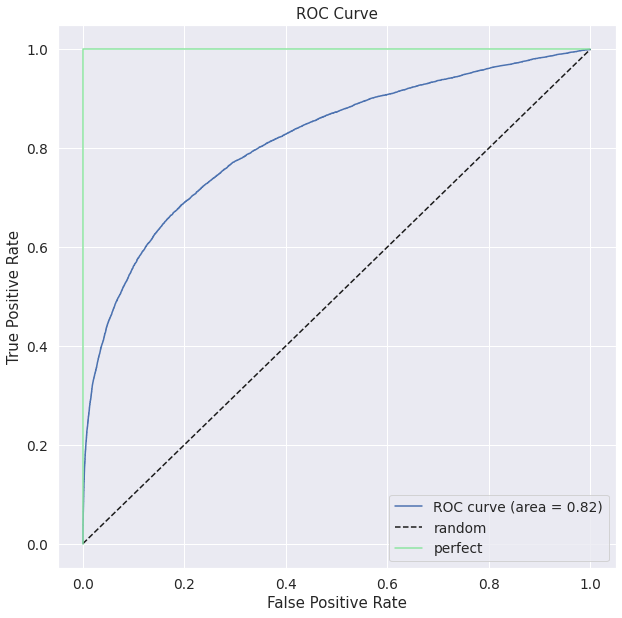

In [49]:
# Plot the ROC curve

plot_roc(y_val, pred_prob_val_xgb)

#### 5.2.2 Capture Plot (For Returning Customers)

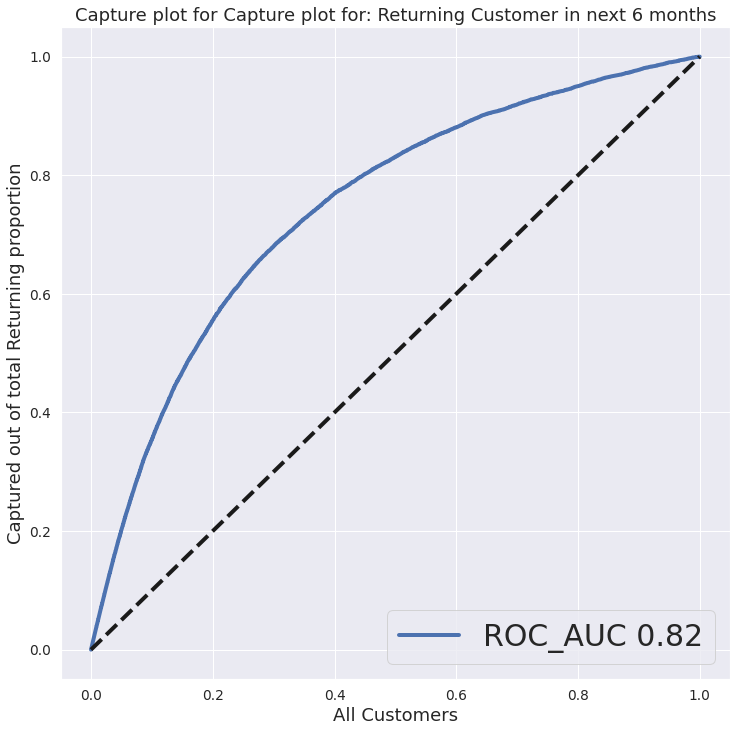

In [50]:
# Capture plot

capture_curve(df_val, df_val['is_returning_customer'], pred_prob_val_xgb, round(roc_val_xgb,2), 'Capture plot for: Returning Customer in next 6 months')


* The capture curve shows, if we consider the top 60% of the customers based on predicted probability, we capture around 90% of the Returning customers.

** This can be confirmed based on multiple sample selection test and can be strengthen by checking the real-time test data or online tests etc.

#### 5.2.3 Decile-based probability

In [58]:
# Create a copy of validation dataset for concatenating the predictions
df_val_preds = df_val.copy()
# prediction from XGBoost model
pred_val = pred_prob_val_xgb
df_val_preds['preds']=list(pred_val)
# Sort the customers based on descending order of predicted probability
sorted_df_val_preds = df_val_preds.sort_values(by ='preds' , ascending=False)
sorted_df_val_preds.shape

(48988, 54)

In [59]:
# Columns of the sorted dataframe

sorted_df_val_preds.columns

Index(['customer_id', 'first_order_before', 'last_order_before',
       'cntns_order_period', 'comm_orderhour', 'num_success_order',
       'num_fail_order', 'is_voucher', 'avg_voucher_amnt', 'is_deliveryfee',
       'avg_deliveryfee', 'is_amount', 'avg_amount', 'num_restaurant',
       'num_city', 'num_paymentid', 'num_platform', 'num_transmission',
       'order_afternoon', 'order_early_morning', 'order_evening',
       'order_late_night', 'order_morning', 'order_night', 'payment_id_1491',
       'payment_id_1523', 'payment_id_1619', 'payment_id_1779',
       'payment_id_1811', 'platform_id_525', 'platform_id_22167',
       'platform_id_22263', 'platform_id_22295', 'platform_id_29463',
       'platform_id_29495', 'platform_id_29751', 'platform_id_29815',
       'platform_id_30135', 'platform_id_30199', 'platform_id_30231',
       'platform_id_30359', 'platform_id_30391', 'platform_id_30423',
       'transmission_id_212', 'transmission_id_1988', 'transmission_id_4196',
       'transmi

In [60]:
# Decile-wise actual retruning customers' %, count, avergae, minimum and maximum probability

df_decile_cutoff_val = decile_cutoff_return_detected(sorted_df_val_preds, 'customer_id', 'is_returning_customer', 'preds')
df_decile_cutoff_val

,customer_population_%,return_%,return_count,avg_pred_prob,min_pred_prob,max_pred_prob
0,10,35.44,3900,0.79,0.59,0.98
1,20,20.12,2214,0.46,0.35,0.59
2,30,12.47,1372,0.28,0.23,0.35
3,40,8.90,979,0.19,0.16,0.23
4,50,6.18,680,0.15,0.13,0.16
5,60,4.97,547,0.12,0.10,0.13
6,70,3.85,424,0.09,0.08,0.10
7,80,3.12,343,0.07,0.07,0.08
8,90,2.72,299,0.06,0.06,0.07
9,100,2.24,246,0.05,0.03,0.06


In [61]:
# Decile-wise actual cumulative retruning customers' %, count, avergae, minimum and maximum probability

df_cum_decile_cutoff_val = cum_decile_cutoff_return_detected(sorted_df_val_preds, 'customer_id', 'is_returning_customer', 'preds')
df_cum_decile_cutoff_val

,customer_population_%,cumulative_return_%,cumulative_return_count,avg_pred_prob,min_pred_prob,max_pred_prob
0,10,35.44,3900,0.79,0.59,0.98
1,20,55.56,6114,0.62,0.35,0.98
2,30,68.03,7486,0.51,0.23,0.98
3,40,76.93,8465,0.43,0.16,0.98
4,50,83.11,9145,0.37,0.13,0.98
5,60,88.08,9692,0.33,0.10,0.98
6,70,91.93,10116,0.30,0.08,0.98
7,80,95.05,10459,0.27,0.07,0.98
8,90,97.76,10758,0.25,0.06,0.98
9,100,100.00,11004,0.23,0.03,0.98


* This decile-based population can be used for different business scenarios such as Marketing models(Promotions, Discounts etc), Customer retention programs.

* Based on confidence of customer returning, budget for promotions, risk-appetite, other models output such as Life-time value analysis etc, population of crop can be treated as Returning or non-returning customers.

## 6. Hyperparameter Tuning

* Let's tune the hyperparameter of XGBoost model with Gridsearch

In [51]:
# start_time=time.time()

# #### Create X and Y training data here.....


# # grid search
# model = XGBClassifier()

# param_grid = {
#         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#         'min_child_weight': [0.01, 0.05, 0.1, 0.5],
#         'gamma': [0, 10, 20, 40],
#         'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]}
#         # 'min_child_weight': np.arange(0.0001, 0.5, 0.001),
#         # 'gamma': np.arange(0.0,40.0,0.005),
#         # 'learning_rate': np.arange(0.0005,0.3,0.0005),
#         # 'subsample': np.arange(0.01,1.0,0.01),
#         # 'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01),2),
#         # 'colsample_bytree': np.arange(0.1,1.0,0.01)}

# kfold = KFold(n_splits=10, shuffle=True, random_state=10)
# grid_search = RandomizedSearchCV(model, param_grid, scoring="accuracy", n_iter = 500, cv=kfold)
# grid_result = grid_search.fit(X_train,y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_[ 'mean_test_score' ]
# stds = grid_result.cv_results_[ 'std_test_score' ]
# params = grid_result.cv_results_[ 'params' ]

# print(time.time()-start_time) 

* In future, I can try tuning hyperparameters as it takes good amount of time

* Let's try a random model and see if it is better than default model

In [62]:
### XGBoost Model with random parameters

random_xgb = XGBClassifier(learning_rate =0.01,
 n_estimators=100,
 max_depth=5,
 min_child_weight=6,
 gamma=0,
 subsample=0.84,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 seed=21)

# train the random model
random_xgb.fit(X_train, y_train)
# prediction
pred_prob_val_random_xgb = random_xgb.predict_proba(X_val)[:, 1]
pred_val_random_xgb = random_xgb.predict(X_val)
# f1-score calculation
f1_score_random_xgb= f1_score(y_val_list, pred_val_random_xgb)
# roc calculation
roc_val_random_xgb = roc_auc_score(list(y_val), pred_prob_val_random_xgb)

In [63]:
# Cross-check the model's hyperparameters
pprint(random_xgb.get_params)

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=21,
              silent=None, subsample=0.84, verbosity=1)>


In [64]:
# F1-score and ROC
print(f'Random XGBoost Classifier F1-score: {round(f1_score_random_xgb,2)}')
print(f'Random XGBoost Classifier ROC: {round(roc_val_random_xgb,2)}')

Random XGBoost Classifier F1-score: 0.54
Random XGBoost Classifier ROC: 0.82


* Although ROC is same, F1-score is better with default parameters than the random ones.
* So, will stick to model with default parameters